# Cours 4: Méthodes et algorithmes

## Introduction

Lors des précédentes séances, nous avons vu comment :

- construire et mesurer un circuit quantique ;
- implémenter une méthode permettant de rajouter une porte quantique à un circuit ;
- implémenter la transformée de Fourier quantique pour un nombre donné de qubits ;
- comment implémenter l'inverse d'une opération quantique dont la transformée de Fourier quantique ;

Dans le cadre de séance, nous verrons :

- comment implémenter une estimation de phase.
- comment gagner de la modularité grâce aux objets Gate ;
- une mise en pratique d'utilisation de ces objets Gate.

Pour cela, nous diviserons la séance en :

- L'algorithme d'estimation de phase
- une présentation des objets Gate ;
- des exercices d'appropriation de ces objets ;
- une démonstration du gain de modularité avec l'exemple d'un *do_swaps* contrôlé.


### Nom et prénom


Commençons par inscrire votre nom et prénom en tant qu'objet string nom_prenom. Nous utiliserons comme convention :

- Un _ séparera le nom et le prénom.

Ainsi :

- Pour Jean-Pierre Pernault, nom_prenom = 'Pernault_Jean-Pierre'.

In [1]:
nom_prenom = 

## Quelques fonction utiles héritées de la séance précédente

In [3]:
from qiskit.circuit import Qubit, QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.providers.basic_provider import BasicProvider
backend = BasicProvider().get_backend("basic_simulator")
from math import pi

def porte_SWAP(circuit, qubits):
    
    if type(circuit) == QuantumCircuit:
        
        if len(qubits) == 2:
            
            if type(qubits[0]) == Qubit and type(qubits[1]) == Qubit:
                circuit.cx(qubits[0], qubits[1])
                circuit.cx(qubits[1], qubits[0])    
                circuit.cx(qubits[0], qubits[1])
            
            elif type(qubits[0]) == int and type(qubits[1]) == int:
                q = circuit.qubits
                circuit.cx(q[qubits[0]], q[qubits[1]])
                circuit.cx(q[qubits[1]], q[qubits[0]])    
                circuit.cx(q[qubits[0]], q[qubits[1]])
                
    return circuit

def do_swaps(circuit, registre):
    for i in range(len(registre) // 2) :
        circuit = porte_SWAP(circuit, [registre[i], registre[len(registre) - 1 - i]])
    return circuit

def inverse_R(k, circuit, qubit_controle, qubit_cible):
    circuit.cp(-pi/2**k, qubit_controle, qubit_cible)
    return circuit

def inverse_QFT(circuit, registre, to_swap=True):
    
    if to_swap:
        circuit = do_swaps(circuit, registre)
        
    for i in range(len(registre)):
        i = len(registre) - 1 - i
        
        for distance in range(len(registre) - i - 1):
            distance = distance + 1
            circuit = inverse_R(distance, circuit, registre[distance + i], registre[i])
            
        circuit.h(registre[i])
        
    return circuit

## Estimation de phase

L'estimation de phase est un algorithme quantique très particulier et très utilisé pour les méthodes Monte-Carlo quantiques puisqu'il permet de construire un estimateur d'amplitude (cf. *Quantum Amplitude Amplification and Estimation* de Brassard et al., 2000), l'amplitude pouvant contenir des informations sur un problème donné (la probabilité d'obtenir une mesure donnée correspondant à un phénomène physique, d'ingénierie etc.). 


Nous pouvons le résumer ainsi : supposons que nous ayons un opérateur quantique $U$ qui soit un oracle, i. e. une boîte noire dont nous ne connaissons rien à part un état propre |$\psi$> mais sans savoir quelle est sa valeur propre :

$$U | \psi> = e^{i \phi} | \psi >.$$

L'objectif de cet algorithme est d'obtenir cette valeur propre. En pratique, l'algorithme donnera la valeur $z$ telle que $$\phi = \frac{2 \pi \, z}{2^n}$$

avec $n$ le nombre de qubits.

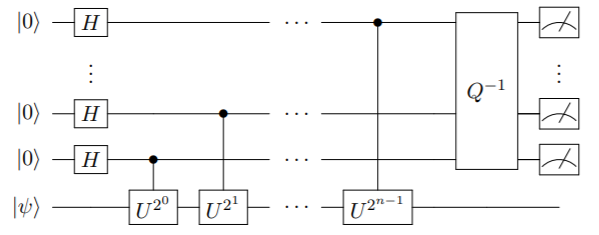

Nous constatons qu'il faut diviser les qubits en deux registres :

- un premier registre qui sera le seul mesuré ;
- un second registre où sera implémenté l'état quantique $| \psi >$ de même dimension que le premier registre.

Nous décomposerons cette partie en trois sous-parties :

- un exemple d'application de l'algorithme d'estimation de phase ;
- un exercice-bonus avec pour oracle NOT sur un registre de dimension 1 ;
- un exercice-bonus sur un registre de dimension 2.


### Exemple d'application de l'algorithme d'estimation de phase

Commençons par un exemple d'oracle *exemple_oracle* tel que :

- il s'applique sur un registre quantique de dimension 1 ;
- il dépend d'un paramètre *z* que nous choisirons arbitrairement ne prenant que les valeurs 0 ou 1 ;
- l'état |1> en soit un état propre.

In [2]:
def exemple_oracle(z, circuit, registre_dim1):
    n = len(registre_dim1)
    angle = 2 * pi * z / 2**n
    circuit.p(angle, registre_dim1)
    return circuit

Du circuit générique présenté ci-dessus, nous constatons que nous avons besoin de contrôler *exemple_oracle*. Faisons-le manuellement :

In [2]:
def c_exemple_oracle(z, circuit, etat_propre_dim1, registre_mesure_dim1):
    n = len(registre_mesure_dim1)
    angle = 2 * pi * z / 2**n
    circuit.cp(angle, registre_mesure_dim1, etat_propre_dim1)
    return circuit

Etant donné que nous resterons sur deux registres quantiques de dimension 1, il n'y aura pas besoin d'utiliser des puissances de l'oracle. Créons maintenant le circuit quantique *exemple_circ* pour l'estimation de phase :

In [ ]:
n = 1
registre_mesure = QuantumRegister(n)
registre_etat_propre = QuantumRegister(n)
clbits = ClassicalRegister(n)

exemple_circ = QuantumCircuit(registre_mesure, clbits)
exemple_circ.add_register(registre_etat_propre)

La structure du circuit quantique *exemple_circ* est prête, il s'agit maintenant de faire agir l'estimation de phase. Voici le circuit quantique (attention, qft devrait être remplacé par inverse_qft !) :

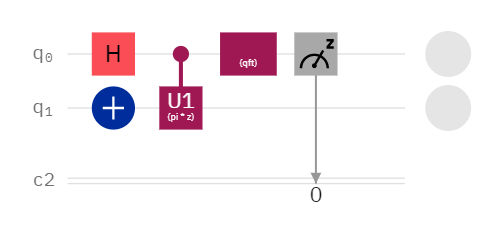

Il faut bien comprendre que le NOT agissant sur le second qubit prépare l'état propre |1> de notre oracle *exemple_oracle*.

**1) Préparez l'état propre.**

**2) Appliquez maintenant l'algorithme d'estimation de phase.**

In [ ]:
z = 1

In [ ]:
exemple_circ.draw(output='mpl')

**3) Vérifiez que lorsque vous prenez z = 0, vous obtenez en résultat 0, et lorsque vous prenez z = 1, vous obtenez 1.**

*Remarque : Faites bien attention à réinitialiser le circuit quantique !*

In [ ]:
exemple = backend.run(exemple_circ, shots=1000).result().get_counts()
print(exemple)

In [ ]:
if z%2 == 0:
    assert exemple['0'] == 1000
    
else :
    assert exemple['1'] == 1000

Ceci correspond à :

- soit obtenir une valeur propre $e^{i 0} = 1$ pour z = 0 ;
- soit obtenir une valeur propre $e^{i \pi} = - 1$ pour z = 1.

### Exercice-bonus : Oracle NOT

Nous choisirons cette fois comme oracle la porte NOT qui bien sûr n'agit que sur des registres quantiques de dimension 1. Nous donnerons comme état propre :

$$|-> = H (NOT) |0> = Z H |0>.$$

**1) Construisez l'oracle contrôlé** *c_NOT* **de la même manière que précédement :**

In [4]:
def c_NOT(circuit, etat_propre_dim1, registre_mesure_dim1):
    circuit.cx(registre_mesure_dim1, etat_propre_dim1)
    return circuit

**2) Préparez la structure globale du circuit que nous nommerons** *circ_not :*

**3) Préparez l'état propre.**

**4) Appliquez maintenant l'algorithme d'estimation de phase.**

In [ ]:
circ_not.draw(output='mpl')

In [ ]:
res_not = backend.run(circ_not, shots=1000).result().get_counts()
print(res_not)

In [ ]:
assert res_not['1'] == 1000

Le fait qu'on obtienne la valeur 1 pour notre état propre revient à dire que nous obtenons la valeur propre $e^{i \pi} = -1$.

### Exercice-bonus

Nous allons maintenant nous arrêter sur un oracle *oracle2* qui peut s'appliquer sur un registre quantique de dimension 2, tels que ses états propres sont les états fondamentaux |00>, |10>, |01>, |11> : 

In [ ]:
def oracle2(z, circuit, registre_quantique_dim2):
    n = len(registre_quantique_dim2)
    angle = 2 * pi * z / 2**n
    circuit.p(angle, registre_quantique_dim2[0])
    return circuit

Cette fois, nous prendrons pour le paramètre $z$ les valeurs entières de 0 à 3.

**Construisez l'oracle contrôlée associée** *c_oracle2.*

In [ ]:
def c_oracle2(z, circuit, registre_etat_propre, qubit_controle):
    n = len(registre_etat_propre)
    angle = 2 * pi * z / 2**n
    circuit.cp(angle, qubit_controle, registre_etat_propre[0])
    return circuit

**Préparez la structure globale du circuit quantique.**

**Préparez l'état propre que vous souhaitez.**

**Appliquez maintenant l'estimation de phase.**

In [ ]:
z = 2

In [ ]:
circ.draw(output='mpl')

In [ ]:
resultats1 = backend.run(circ, shots=1000).result().get_counts()
print(resultats1) #On est dans la convention LSBF !!! Attention !!!!

**Amusez-vous à faire varier le paramètre** *z* **puis faites de même avec l'état propre.**

*Remarque : une nouvelle fois, n'oubliez pas de réinitialiser le circuit au complet !*

## Une première approche des objets Gate

Lors de nos différentes séances, nous avions vu comment représenter dans Qiskit les éléments fondamentaux utiles à l'implémentation d'algorithmes quantique. Dans ce cadre, nous avons vu que les opérations quantiques élémentaires se résumaient en des instructions données directement pour des objets QuantumCircuit.

Nous allons voir un type d'objet différent, les objets Gate, qui présentent l'avantage d'être plus modulables et se rapprochent de l'idée qu'on se fait d'une porte quantique.


### Quelques objets Gate élémentaires

Les objets Gate jouent le rôle des portes quantiques. Tout comme les instructions qui nécessitaient des instructions élémentaires déjà implémentées (mettre une porte NOT avec la commande *circuit.x()*, etc.), nous aurons besoin d'un certain nombre d'objets Gate déjà implémentés par Qiskit afin de pouvoir définir les nôtres. 

Nous allons faire un rapide tour des objets Gate qui nous serons utiles dans ce Jupyter Notebook. Ce seront les objets Gate associés aux portes NOT, Hadamard, CNOT et CU1 **(CP dans la nouvelle version de Qiskit)**. Si jamais vous souhaitez utiliser des portes différentes, je vous conseille de jeter un coup d'oeil à la documentation associée.

Commençons par la **porte NOT** représentée par l'objet XGate.

In [2]:
from qiskit import QuantumRegister, QuantumCircuit

q = QuantumRegister(1)
circ = QuantumCircuit(q)

Nous avons un circuit quantique sur lequel nous souhaitons appliquer une porte NOT. La syntaxe à utiliser est celle-ci pour bien avoir une porte NOT implémentée :

In [3]:
from qiskit.circuit.library.standard_gates import XGate
# from qiskit.extensions.standard.x import XGate

circ.append(XGate(), q)

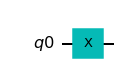

In [4]:
circ.draw(output='mpl')

*Remarque : le deuxième argument du append doit :*

- *soit être un registre quantique ;*
- *soit être une liste d'objets Qubit ;* 
- *soit être une liste des indices des qubits du circuit.*

*Cela ne peut pas être un objet Qubit seul. Ainsi si vous voulez faire agir votre porte spécifiquement sur q[0], vous devrez donner en argument soit [q[0]], soit [0].*

Après la porte NOT, vous allez maintenant appliquer une **porte d'Hadamard** sur ce circuit (je vous laisse deviner la syntaxe).

In [5]:
# from qiskit.extensions.standard.h import HGate
from qiskit.circuit.library.standard_gates import HGate

circ.append(HGate(), q)

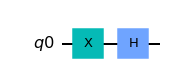

In [6]:
circ.draw(output='mpl')

Nous allons maintenant faire de même pour la **porte CNOT** :

In [7]:
# from qiskit.extensions.standard.x import CnotGate
from qiskit.circuit.library.standard_gates import CXGate

circ.add_register(QuantumRegister(1))

circ.append(CXGate(), circ.qubits[0:2])

In [8]:
circ.qubits

[Qubit(QuantumRegister(1, 'q0'), 0), Qubit(QuantumRegister(1, 'q1'), 0)]

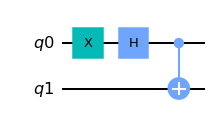

In [9]:
circ.draw(output='mpl')

**1) Faites une mesure de ce circuit pour vérifier que vous obtenez bien un état de Bell.**

*Remarque : Bien sûr, il ne s'agit pas de l'état de Bell que vous aviez déjà implémenté !*

In [ ]:
from qiskit.circuit import ClassicalRegister
from qiskit.providers.basic_provider import BasicProvider
backend = BasicProvider().get_backend("basic_simulator")

shots = 1000



job_bell = 

In [ ]:
res_bell = job_bell.result().get_counts()
print(res_bell)

In [ ]:
from math import isclose
assert isclose(res_bell['00'], shots/2, rel_tol=0.2) and isclose(res_bell['11'], shots/2, rel_tol=0.2)

### Exercice

**1) Créez maintenant un nouveau circuit** *circ2* **de taille 2 et appliquez :**

- *sur le premier qubit un objet Gate qui soit une porte NOT ;* 
- *puis sur le second qubit un objet Gate qui soit une porte d'Hadamard ;* 
- *puis un objet Gate qui soit une rotation de phase d'argument* $\pi$ *contrôlée par le premier qubit sur le second qubit ;*
- *puis sur le second qubit un objet Gate qui soit une porte d'Hadamard de nouveau ;*
- *enfin, mesurez les deux qubits. Vous nommerez le dictionnaire des résultats mesures*

In [ ]:
from qiskit.circuit.library.standard_gates import CPhaseGate
from math import pi

shots = 1000

circ2 = 

mesures =

In [ ]:
circ2.draw(output='mpl')

In [ ]:
assert mesures['11'] == 1000

## Nos propres objets Gate

Nous allons maintenant créer nos propres objets Gate. Pour ce faire, nous aurons deux stratégies possibles :

- convertir directement un circuit quantique en objet Gate ;
- créer de but en blanc un objet Gate à partir d'autres objets Gate.

### Conversion d'un circuit quantique en objet Gate

Grâce à la méthode *to_gate()*, il est tout à fait de convertir un circuit quantique en objet Gate. 

**1) Construisez un circuit quantique** *dummy* **sans bit classique qui reprendra vos instructions unitaires (i. e. sans les mesures) de** *circ2.*

In [ ]:
dummy = 

In [ ]:
dummy.draw(output='mpl')

Il est maintenant possible de construire un objet Gate *dummy_gate* contenant toute ces instructions unitaires :

In [ ]:
dummy_gate = dummy.to_gate()

**2) Appliquez maintenant cet objet Gate sur un nouveau circuit quantique** *circuit.*

*Remarque : vous noterez bien que la porte dummy_gate n'a plus de paramètre à mettre en entrée. Tout comme les tuples, elle n'est pas mutable.*

In [ ]:
circuit = 

In [ ]:
circuit.draw(output='mpl')

Nous pouvons constater que la visualisation est peu explicite puisqu'elle ne montre pas les composantes de l'objet Gate nouvellement créée. Voici la syntaxe pour que cette décomposition soit faite :

In [ ]:
circuit.decompose().draw(output='mpl')

**3) Faites maintenant la mesure et vérifiez que cela donne bien le même résultat que pour** *circ2.*

In [ ]:

dummy_mesures = 

In [ ]:
circuit.decompose().draw(output='mpl')

In [ ]:
assert dummy_mesures['11'] == 1000

### Création d'objets Gate

La syntaxe pour crée un objet Gate peut paraître compliquée au premier abord. En fait, il s'agit simplement d'organisation. Ces objets Gate ont des paramètres inaliénables que sont :

- le nom de l'objet Gate *name* ;
- le nombre de qubits sur lequel s'applique la porte quantique *num_qubits*.

Il est possible de rajouter d'autres paramètres, mais nous nous n'aurons pas le temps de le voir. *N'hésitez à revenir vers moi une prochaine fois si cela vous intéresse !*

Commençons par créer un objet Gate *DummyGate* qui aura :

- pour nom *Dummy Gate* ;
- pour nombre de qubits *n* sur lequel il s'applique égal à 1.

Nous ne donnerons pour le moment aucune instruction pour cette porte (il s'agit de la partie *def _define*). Autrement dit, elle agira comme la porte Identité sur un qubit :

In [11]:
from qiskit.circuit import Gate

n = 1

class DummyGate(Gate):
    """Dummy gate."""
    
    def __init__(self):
        super().__init__(name=f"Dummy Gate", num_qubits=n, params=[])  # C'est ici qu'on dit que la porte agit sur n (1) qubits !
        
    def _define(self):
        definition = []
        q = QuantumRegister(n)                       # Nous devons définir un registre quantique générique de la bonne taille
        self.definition = definition

Vérifions ce que cela donne sur un circuit quantique *(j'avoue ne pas savoir pourquoi la méthode decompose() ne fonctionne pas ici...)* :

In [ ]:
exemple_circuit = QuantumCircuit(1)

exemple_circuit.append(DummyGate(), exemple_circuit.qubits)

In [ ]:
exemple_circuit.draw(output='mpl')

Reconstruisons maintenant un objet *DummyGate* tel que :

- son nom soit toujours *Dummy Gate* ;
- il agisse toujours sur un seul qubit ;
- il applique une porte d'Hadamard.

Voici la syntaxe associée :

In [ ]:
n = 1

class DummyGate(Gate):
    """Dummy gate."""
    
    def __init__(self):
        super().__init__(name=f"Dummy Gate", num_qubits=n, params=[])
        
    def _define(self):
        q = QuantumRegister(n)  
        definition = QuantumCircuit(q)
        definition.append(HGate(), [q[0]], [])     # Voici la syntaxe pour rajouter une instruction
        self.definition = definition

**1) Redéfinissez** *exemple_circuit* **pour que ne soit appliquée que cette version de** *DummyGate.*

In [ ]:
exemple_circuit = 

*Remarque : cette fois, la méthode decompose() fonctionne.*

In [ ]:
exemple_circuit.decompose().draw(output='mpl')

**2) Définissez maintenant un objet Gate** *MonObjetGate* **tel que :**

- *son nom soit "Mon objet Gate" ;*
- *il agisse sur un seul qubit ;*
- *il applique une porte d'Hadamard puis une porte NOT ;* 

**puis redéfinissez de nouveau** *exemple_circuit* **pour appliquer cette porte.**

In [ ]:
class MonObjetGate(Gate):
    """Mon objet gate."""
    


In [ ]:
exemple_circuit = 

In [ ]:
exemple_circuit.decompose().draw(output='mpl')

Pour ne pas trop allonger la taille de ce Jupyter Notebook (qui sera déjà suffisamment long), voici un exemple d'objet Gate nommé *PorteBell* dont vous reconnaîtrez l'action et qui permet d'illustrer le cas où *num_qubits* = 2 :)

In [12]:
n = 2

class PorteBell(Gate):
    """Porte Bell."""
    
    def __init__(self):
        super().__init__(name=f"Porte Bell", num_qubits=n, params=[])  
        
    def _define(self):
        q = QuantumRegister(n)
        definition = QuantumCircuit(q)
        definition.append(HGate(), [q[0]], [])
        definition.append(CXGate(), q, [])
        self.definition = definition

In [13]:
exemple_circuit = QuantumCircuit(2)

exemple_circuit.append(PorteBell(), exemple_circuit.qubits)

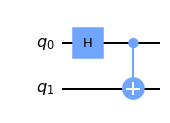

In [14]:
exemple_circuit.decompose().draw(output='mpl')

Nous allons maintenant créer une porte telle que le nombre de qubits soit un **paramètre à donner**. Redéfinissons la porte *DummyGate* pour cela telle qu'elle fasse agir une porte XGate sur les qubits d'indices pairs et une porte HGate sur les qubits d'indices impairs  :

In [15]:
class DummyGate(Gate):
    """Dummy gate."""
    
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits # Cette variable interne doit être définie pour qu'elle soit prise en compte dans la méthode _define                      
        super().__init__(name=f"Dummy Gate", num_qubits=num_qubits, params=[]) 
        
    def _define(self):
        q = QuantumRegister(self.num_qubits)
        definition = QuantumCircuit(q)
        for i in range(self.num_qubits):
            if i % 2 == 0 :
                definition.append(XGate(), [q[i]], [])
            else :
                definition.append(HGate(), [q[i]], [])
        self.definition = definition

In [16]:
n = 4

exemple_circuit = QuantumCircuit(n)

exemple_circuit.append(DummyGate(n), exemple_circuit.qubits)

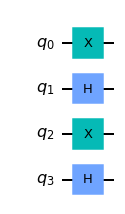

In [17]:
exemple_circuit.decompose().draw(output='mpl')

Nous pratiquons tout ceci lors de la prochaine partie.

## Gain de modularité

Avant de vraiment prendre la main sur les objets Gate, il s'agit de répondre à ces questions : *pourquoi les utiliser ? N'est-ce pas simplement se compliquer la vie ?*

La réponse à cette dernière question est évidemment non, et ce pour plusieurs raisons :

- si nous souhaitons contrôler un circuit quantique, il faut en fait en reconstruire un au complet ce qui n'est pas le cas pour les objets Gate ;
- il est facile d'inverser un objet Gate ;
- les méthodes impliquant des objets Gate sont en conséquence bien plus modulables.

Nous prendrons dans cette partie deux exemples :

- la méthode *do_swaps* contrôlée ;
- la méthode *QFT* contrôlée.

### La méthode *do_swaps* contrôlée

Nous nous souvenons de notre méthode *do_swaps* :

In [18]:
def porte_SWAP(circuit, qubits):
    
    if type(circuit) == QuantumCircuit:
        
        if len(qubits) == 2:
            circuit.cx(qubits[0], qubits[1])
            circuit.cx(qubits[1], qubits[0])    
            circuit.cx(qubits[0], qubits[1])
               
    return circuit


def do_swaps(circuit, registre):
    for i in range(len(registre) // 2) :
        circuit = porte_SWAP(circuit, [registre[i], registre[len(registre) - 1 - i]])
    return circuit

Avant de construire sa version contrôlée, nous construirons l'équivalent de *do_swaps* en objet Gate que nous nommerons DoSwaps.

**1) Construisez un objet Gate** *PorteSwap* **qui agisse sur deux qubits et qui fasse un SWAP.**

In [ ]:
class PorteSwap(Gate):
    """SWAP gate."""
    
    

In [ ]:
exemple_circuit = QuantumCircuit(2)

exemple_circuit.append(PorteSwap(), exemple_circuit.qubits)

In [ ]:
exemple_circuit.decompose().draw(output='mpl')

**2) Construisez maintenant l'objet Gate** *DoSwaps* **qui prendra en paramètre le nombre de qubits.**

In [ ]:
class DoSwaps(Gate):
    """Do swaps gate."""
    
    

In [ ]:
n = 5

exemple_circuit = QuantumCircuit(n)

exemple_circuit.append(DoSwaps(n), exemple_circuit.qubits)

In [ ]:
exemple_circuit.decompose().decompose().draw(output='mpl')

Nous pouvons maintenant passer à la version simple contrôlée de *do_swaps*. Pour construire sa version contrôlée, nous aurons besoin d'utiliser la méthode *QuantumCircuit.ccx*, autrement appelée porte de Toffoli qui s'appliquer de cette manière :

In [19]:
exemple_circuit = QuantumCircuit(3)
exemple_q = exemple_circuit.qubits
exemple_circuit.ccx(exemple_q[0], exemple_q[1], exemple_q[2])

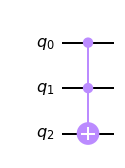

In [20]:
exemple_circuit.draw(output='mpl')

**3) Construisez une méthode** *c_porte_SWAP* **qui soit une porte SWAP simplement contrôlée.**

In [ ]:
def c_porte_SWAP(circuit, ctrl_qubit, qubits):
    
    

In [ ]:
exemple_circuit = QuantumCircuit(3)
ctrl_qubit = exemple_circuit.qubits[0]
exemple_circuit = c_porte_SWAP(exemple_circuit, ctrl_qubit, exemple_circuit.qubits[1:])

In [ ]:
exemple_circuit.draw(output='mpl')

**4) Construisez maintenant une méthode** *c_do_swaps* **qui soit la méthode** *do_swaps* **simplement contrôlée.**

In [ ]:
def c_do_swaps(circuit, ctrl_qubit, registre):
    
    

In [ ]:
n = 5

exemple_circuit = QuantumCircuit(n)
ctrl_qubit = exemple_circuit.qubits[0]

exemple_circuit = c_do_swaps(exemple_circuit, ctrl_qubit, exemple_circuit.qubits[1:])

In [ ]:
exemple_circuit.draw(output='mpl')

Nous allons voir maintenant ensemble comment contrôler l'objet Gate *DoSwaps*. Comme vous vous doutez, cela sera très facile, et ce grâce à la méthode *Gate.control()* :

In [ ]:
num_ctrl_qubits = 1 # Il s'agit du nb de qubits qui contrôlent la porte

class CDoSwaps(Gate):
    """Controlled do swaps gate."""
    
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits
        super().__init__(name=f"Controlled Do Swaps Gate", num_qubits=num_qubits, params=[]) 
        
    def _define(self):
        q = QuantumRegister(self.num_qubits)
        definition = QuantumCircuit(q)
        definition.append(DoSwaps(self.num_qubits - num_ctrl_qubits).control(num_ctrl_qubits), q, []) # C'est ici que ça se passe !
        self.definition = definition

In [ ]:
n = 5

exemple_circuit = QuantumCircuit(n)

exemple_circuit.append(CDoSwaps(n), exemple_circuit.qubits)

In [ ]:
exemple_circuit.decompose().draw(output='mpl')

In [ ]:
exemple_circuit.decompose().decompose().draw(output='mpl')

Comme nous pouvons le constater, dès le moment que l'objet Gate est créé, il est très simple de le contrôler, et ce par un ou même plusieurs qubits. Si nous voulions généraliser une méthode *mc_do_swaps* avec un nombre de qubits de contrôle supérieur à 1, il faudrait réécrire la méthode au complet en utilisant la méthode *QuantumCircuit.mct* ! Cela peut être un bon entraînement, je vous encourage à le faire dans votre temps libre (quand vous en aurez l'envie bien sûr).


Merci encore pour votre attention, votre travail et vos questions !